In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
  except RuntimeError as e:
    print(e)

In [2]:
import tensorflow as tf
import numpy as np
import os
import sklearn
import matplotlib.pyplot as plt
from tensorflow import keras as keras
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist, cifar10
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Concatenate

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
oh_encoder = OneHotEncoder(categories='auto', sparse=False)
y_train_oh = oh_encoder.fit_transform(y_train.reshape(-1, 1))
y_test_oh = oh_encoder.transform(y_test.reshape(-1, 1))
x_train_3d = np.reshape(x_train, (x_train.shape[0], 28, 28, 1))
x_test_3d = np.reshape(x_test, (x_test.shape[0], 28, 28, 1))

In [4]:
x_train_3d.shape

(60000, 28, 28, 1)

In [5]:
n_batch = 50
n_classes = y_train_oh.shape[1]
n_latent = 2
n_channels = 1
n_epoch = 20

In [6]:
def sample_z(args):
    mu, log_var = args
    batch = K.shape(mu)[0]
    eps = K.random_normal(shape=(batch, n_latent))
    return mu + K.exp(log_var / 2) * eps

In [7]:
input_image = Input(shape=(28,28,1,))
input_cond = Input(shape=(n_classes,))

x = Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu', padding="SAME")(input_image)
x = Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu', padding="SAME")(x)
x = Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu', padding="SAME")(x)
n_x_conv = x.shape
x = Flatten()(x)
n_x_flattened = x.shape[1]
x = Dense(64, activation='relu')(x)
x = Dense(n_latent, activation='relu')(x)
x_encoded = Dense(n_latent, activation='relu')(x)
mu = Dense(n_latent, activation='linear')(x_encoded)
log_var = Dense(n_latent, activation='linear')(x_encoded)
# encoder sampler
z = Lambda(sample_z, output_shape=(n_latent,))([mu, log_var])
z_cond = Concatenate(axis=-1)([z, input_cond])

In [8]:
z_in = Input(shape=(n_latent,))
cond_in = Input(shape=(n_classes,))
dec_input = Concatenate(axis=1)([z_in, cond_in])
dec = Dense(n_latent, activation='relu')(dec_input)
dec = Dense(64, activation='relu')(dec)
dec = Dense(n_x_flattened, activation='relu')(dec)
dec = Reshape(tuple(n_x_conv[1:]))(dec)
dec = keras.layers.Conv2DTranspose(
    filters=32, kernel_size=3, strides=(2, 2), activation='relu', padding="SAME", output_padding=0)(dec)
dec = keras.layers.Conv2DTranspose(
    filters=64, kernel_size=3, strides=(2, 2), activation='relu', padding="SAME")(dec)
x_out = keras.layers.Conv2DTranspose(
    filters=1, kernel_size=3, strides=(2, 2), activation='relu', padding="SAME")(dec)

In [9]:
encoder = Model([input_image, input_cond], [mu, log_var, z, input_cond])
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 4, 4, 32)     18464       ['conv2d_1[0][0]']               
                                                                                              

In [10]:
decoder =  Model([z_in, cond_in], x_out)
decoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 12)           0           ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 2)            26          ['concatenate_1[0][0]']    

In [11]:
output = decoder(encoder([[input_image, input_cond]])[2:])

In [12]:
# loss
reconstruction_loss = keras.losses.binary_crossentropy(keras.layers.Flatten()(input_image), 
                                                       keras.layers.Flatten()(output)) * 28**2
kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
cvae_loss = reconstruction_loss + kl_loss

cvae = Model([input_image, input_cond], output)
cvae.add_loss(cvae_loss)
cvae.compile(optimizer='adam')
cvae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 model (Functional)             [(None, 2),          70260       ['input_1[0][0]',                
                                 (None, 2),                       'input_2[0][0]']                
                                 (None, 2),                                                       
                                 (None, 10)]                                                

In [13]:
# from tensorflow.keras.utils import plot_model
# plot_model(cvae)

In [14]:
# train
cvae.fit([x_train_3d, y_train_oh],
       shuffle=True,
       epochs=50,
       batch_size=50,
       validation_data=([x_test_3d, y_test_oh], None), verbose=1)

Epoch 1/50
1200/1200 [==============================] - 19s 12ms/step - loss: 205.8405 - val_loss: 181.8559
Epoch 2/50
1200/1200 [==============================] - 14s 11ms/step - loss: 178.5997 - val_loss: 175.8557
Epoch 3/50
1200/1200 [==============================] - 14s 11ms/step - loss: 175.4740 - val_loss: 173.3943
Epoch 4/50
1200/1200 [==============================] - 13s 11ms/step - loss: 174.9467 - val_loss: 174.9239
Epoch 5/50
1200/1200 [==============================] - 14s 12ms/step - loss: 174.4456 - val_loss: 172.8892
Epoch 6/50
1200/1200 [==============================] - 13s 11ms/step - loss: 173.9443 - val_loss: 172.4919
Epoch 7/50
1200/1200 [==============================] - 14s 12ms/step - loss: 174.1055 - val_loss: 173.1213
Epoch 8/50
1200/1200 [==============================] - 13s 11ms/step - loss: 173.7892 - val_loss: 172.2121
Epoch 9/50
1200/1200 [==============================] - 13s 11ms/step - loss: 173.8471 - val_loss: 172.6597
Epoch 10/50
1200/1200 [=====

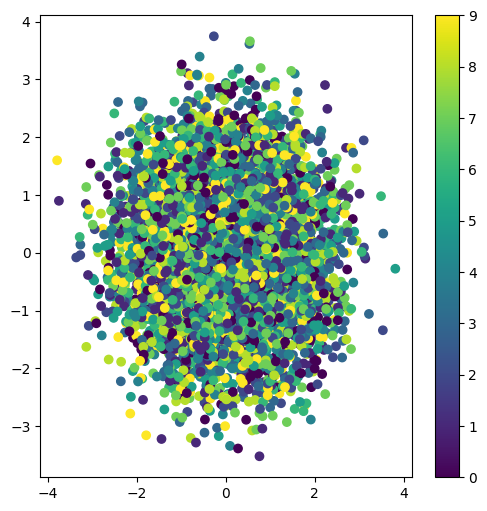

In [15]:
# Plot of the digit classes in the latent space
te_latent = encoder.predict(
    [x_test_3d, y_test_oh], 
    batch_size=50)

pred_mu, pred_var, pred_z, pred_cond = te_latent[0], te_latent[1], te_latent[2], te_latent[3]

plt.figure(figsize=(6, 6))
plt.scatter(pred_z[:, 0], pred_z[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [16]:
def to_categorical(num):
    return oh_encoder.transform([[num]])[0]

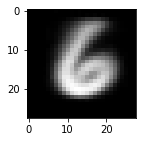

In [17]:
%matplotlib inline
num_class = 6
pred_class = np.array(oh_encoder.transform([[num_class]]))
pred_noise = np.random.randn(1, n_latent)
pred_out = decoder.predict([pred_noise, pred_class])
plt.figure(figsize = (2,2))
plt.imshow(pred_out[0,:,:, 0], cmap='Greys_r',)